In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
import pytorch_lightning as pl
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.tensorboard import SummaryWriter
import segmentation_models_pytorch as smp

2024-11-02 22:39:06.775935: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gokul/.mujoco/mujoco210/bin:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/lib/nvidia
2024-11-02 22:39:06.775956: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
class DenoisingDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, is_train=True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir)
        self.is_train = is_train

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]

        image = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        label = Image.open(os.path.join(self.label_dir, img_name)).convert('L')

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        
        image = (image - image.min()) / (image.max() - image.min())
        
        return image, label

In [4]:
image_size = 256

Transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

train_image_dir = 'dataset/label/Train'
train_label_dir = 'dataset/mask/Train'
val_image_dir = 'dataset/label/Val'
val_label_dir = 'dataset/mask/Val'

trainDataset = DenoisingDataset(train_image_dir, train_label_dir, Transform, is_train=True)
valDataset = DenoisingDataset(val_image_dir, val_label_dir, Transform, is_train=False)

batchSize = 16
trainLoader = DataLoader(trainDataset, batch_size=batchSize, num_workers=0, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=len(valDataset), num_workers=0)

In [5]:
unetmodel = smp.Unet(encoder_name='resnet34',in_channels=3, classes=1)

In [6]:
X, y = next(iter(trainLoader))

In [7]:
yHat = unetmodel(X)

print(yHat.shape)

summary(unetmodel, (3, 256, 256), device="cpu")

torch.Size([16, 1, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
         

In [8]:
writer = SummaryWriter(log_dir='seg_logs')

In [ ]:
lossfn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unetmodel.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

epochs = 25
trainLosses, valLosses = [], []

for epoch in range(epochs):
    unetmodel.train()
    runningLoss = 0.0
    for batchIdx, (images, labels) in enumerate(trainLoader):

        yHat = unetmodel(images)
        l1_loss = lossfn(yHat, labels)
        total_loss = l1_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        writer.add_scalar('Loss/Train', total_loss.item(), epoch*len(trainLoader)+batchIdx)
        runningLoss += total_loss.item()
    
    scheduler.step()

    avg_train_loss = runningLoss / len(trainLoader)
    trainLosses.append(avg_train_loss)
    writer.add_scalar('Training Loss', avg_train_loss, epoch)
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss: .4f}')

    if (epoch + 1) % 5 == 0:
        torch.save(unetmodel.state_dict(), f"unet_epoch_{epoch+1}.pth")
        print(f"Model weights saved at epoch {epoch+1}")

writer.close()
torch.save(unetmodel.state_dict(), "unet_model.pth")
print("Model Weights Saved Successfully")

In [8]:
from networks import RIDNet

unetmodel_path = torch.load("saved_models/unet_model.pth")
unetmodel.load_state_dict(unetmodel_path)

ridnetmodel_path = torch.load("saved_models/ridnet_model.pth")
ridnet = RIDNet()
ridnet.load_state_dict(ridnetmodel_path)

/tmp/ipykernel_33276/3428041887.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unetmodel_path = torch.load("saved_models/unet_model.pth")
/tmp/ipykernel_33276/342804188

<All keys matched successfully>

In [9]:
Xval, yVal = next(iter(trainLoader))

yValPred = unetmodel(Xval[0:8, :, :, :])

In [10]:
noiseImg = Transform(Image.open("dataset/data/Train/003.png"))
cleanImg = Transform(Image.open("dataset/label/Train/003.png"))
maskImg = Transform(Image.open("dataset/mask/Train/003.png"))

In [11]:
denoisedImg = ridnet(noiseImg.unsqueeze(0))
cleanImgMask = unetmodel(cleanImg.unsqueeze(0))
denoisedImgMask = unetmodel(denoisedImg)

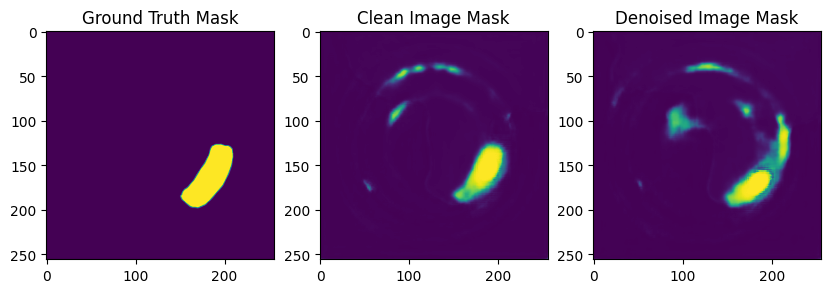

In [12]:
_, ax = plt.subplots(1, 3, figsize=(10, 8))

ax[0].imshow(maskImg.detach().numpy().transpose(1, 2, 0))
ax[0].set_title("Ground Truth Mask")
ax[1].imshow(torch.sigmoid(cleanImgMask).squeeze().detach().numpy())
ax[1].set_title("Clean Image Mask")
ax[2].imshow(torch.sigmoid(denoisedImgMask).squeeze().detach().numpy())
ax[2].set_title("Denoised Image Mask")

plt.show();

In [95]:
y_clean, y_denoise, y_true = torch.sigmoid(cleanImgMask > 0.5), torch.sigmoid(denoisedImgMask) > 0.5, maskImg > 0.5

y_clean_bin = y_clean.float()
y_denoise_bin = y_denoise.float()
y_true_bin = y_true.float()

In [100]:
intersection = (y_denoise_bin * y_true_bin).sum()
union = y_denoise_bin.sum() + y_true.sum() - intersection
iou = intersection / union

iou
dice_coeff = (2 * intersection) / (y_denoise_bin.sum() + y_true_bin.sum())

print(dice_coeff)

tensor(0.5926)


tensor(0.8850)


tensor(0.9390)

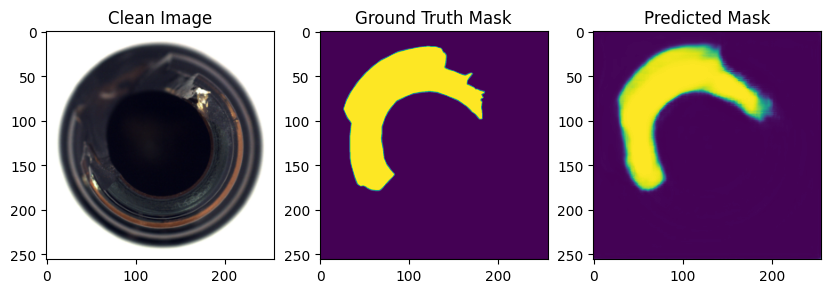

In [18]:
_, ax = plt.subplots(1, 3, figsize=(10, 8))

ax[0].imshow(Xval[3].detach().numpy().transpose(1, 2, 0))
ax[0].set_title("Clean Image")
ax[1].imshow(yVal[3].detach().numpy().transpose(1, 2, 0))
ax[1].set_title("Ground Truth Mask")
ax[2].imshow((torch.sigmoid(yValPred[3])).detach().numpy().transpose(1, 2, 0))
ax[2].set_title("Predicted Mask")


y_pred = torch.sigmoid(yValPred[3]) > 0.5
y_true = yVal[3] > 0.5

y_pred_binary = y_pred.float()
y_true_binary = y_true.float()

pixel_accuracy = (y_pred_binary == y_true_binary).float().mean()
pixel_accuracy

intersection = (y_pred_binary * y_true_binary).sum()
union = y_pred_binary.sum() + y_true_binary.sum() - intersection
iou = intersection / union

print(iou)

dice_coeff = (2 * intersection) / (y_pred_binary.sum() + y_true_binary.sum())

dice_coeff